<h1 style="color: blue;">Anomaly Detection in Credit Card Transactions Using Autoencoders and Transfer Learning Models</h1>

# Importing Libraries and Load Dataset

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [3]:
# Load dataset
data = pd.read_csv('creditcard_data.csv')

In [4]:
# Display basic dataset information
print("Dataset Info:")
print(data.info())
print("\nDataset Head:")
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284806 entries, 0 to 284805
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284806 non-null  float64
 1   V1      284806 non-null  float64
 2   V2      284806 non-null  float64
 3   V3      284806 non-null  float64
 4   V4      284806 non-null  float64
 5   V5      284806 non-null  float64
 6   V6      284806 non-null  float64
 7   V7      284806 non-null  float64
 8   V8      284806 non-null  float64
 9   V9      284806 non-null  float64
 10  V10     284806 non-null  float64
 11  V11     284806 non-null  float64
 12  V12     284806 non-null  float64
 13  V13     284806 non-null  float64
 14  V14     284806 non-null  float64
 15  V15     284806 non-null  float64
 16  V16     284806 non-null  float64
 17  V17     284806 non-null  float64
 18  V18     284806 non-null  float64
 19  V19     284806 non-null  float64
 20  V20     284806 non-null  float64
 

In [5]:
# Check for class imbalance
print("\nClass Distribution:")
print(data['Class'].value_counts())


Class Distribution:
Class
0    284314
1       492
Name: count, dtype: int64


# Exploratory Data Analysis

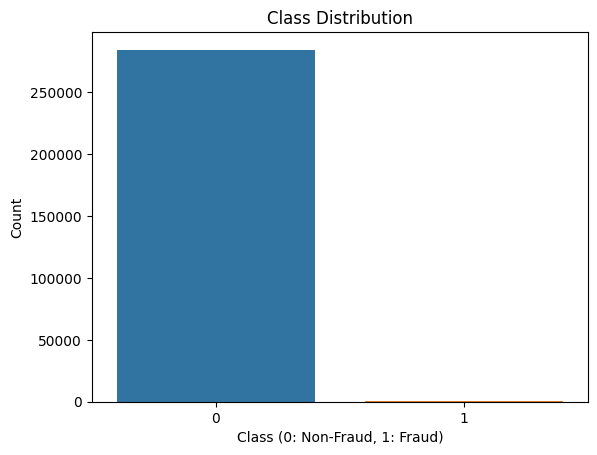

In [6]:
# Distribution of Class
sns.countplot(x='Class', data=data)
plt.title('Class Distribution')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.show()

/home/saky/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


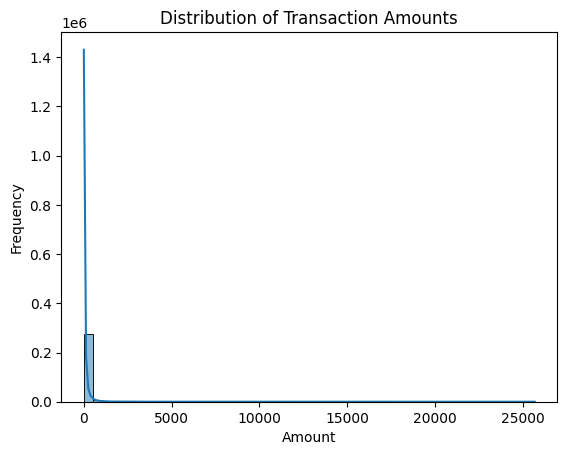

In [7]:
# Distribution of 'Amount'
sns.histplot(data['Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

/home/saky/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


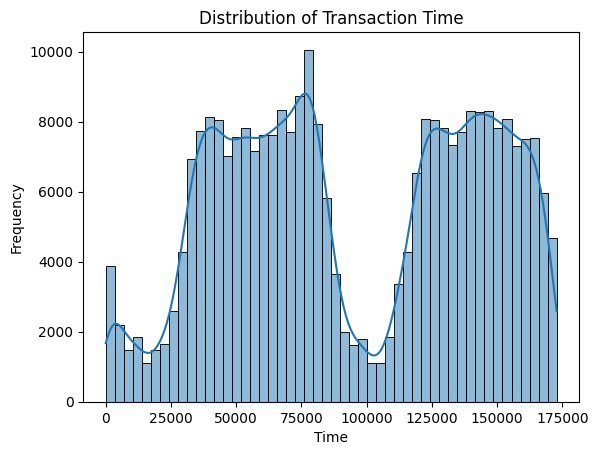

In [8]:
# Distribution of 'Time'
sns.histplot(data['Time'], bins=50, kde=True)
plt.title('Distribution of Transaction Time')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

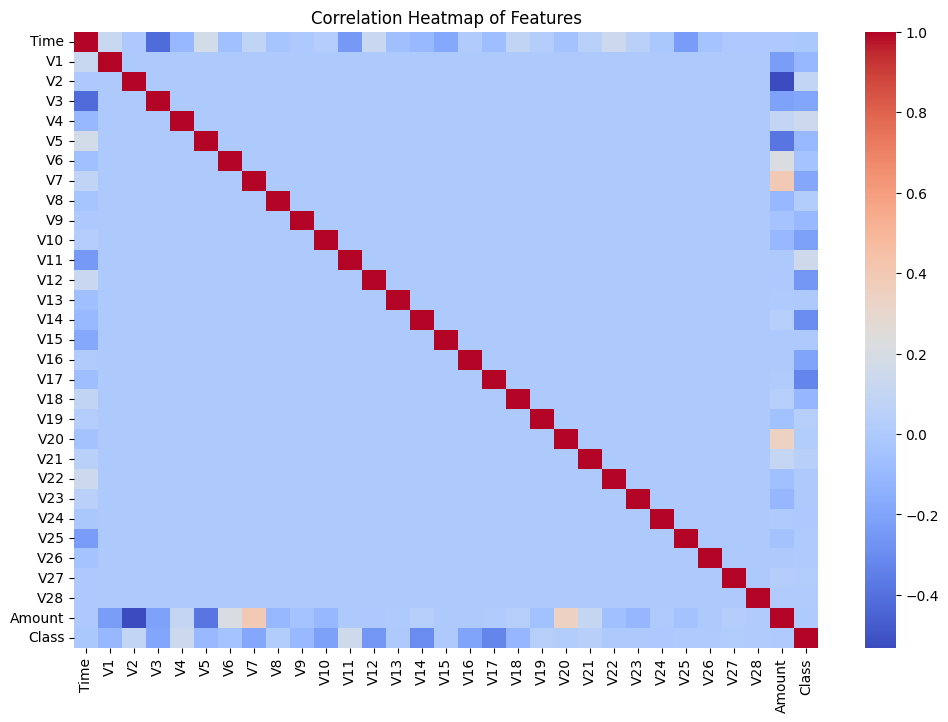

In [9]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False, cbar=True)
plt.title('Correlation Heatmap of Features')
plt.show()

# Pre-processing

In [10]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [11]:
# Feature scaling for 'Amount' and 'Time'
scaler = StandardScaler()
data[['Time', 'Amount']] = scaler.fit_transform(data[['Time', 'Amount']])

In [12]:
# Features and target
X = data.drop('Class', axis=1)
y = data['Class']

In [13]:
# PCA for dimensionality reduction (optional)
pca = PCA(n_components=15)
X_reduced = pca.fit_transform(X)
print(f"\nExplained Variance Ratio by PCA: {pca.explained_variance_ratio_}")


Explained Variance Ratio by PCA: [0.12088216 0.09654339 0.07924925 0.06548464 0.06090455 0.0549235
 0.04985609 0.04372533 0.03692044 0.03686605 0.03580735 0.0307752
 0.03029738 0.02844008 0.02659217]


In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
# Use only normal transactions for training the autoencoder
X_train_normal = X_train[y_train == 0]


# Autoencoder Design and Training

In [22]:
# Autoencoder architecture
input_dim = X_train_normal.shape[1]  # Number of features
encoding_dim = 8  # Bottleneck layer dimension

In [23]:
# Define the Autoencoder model
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

2024-11-25 17:27:27.177670: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [24]:
# Train the autoencoder
start_time = time.time()
history = autoencoder.fit(
    X_train_normal,
    X_train_normal,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    shuffle=True,
    verbose=1
)
end_time = time.time()

print(f"\nAutoencoder Training Time: {end_time - start_time:.2f} seconds")

Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6485 - val_loss: 1.3570
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3327 - val_loss: 1.2863
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2436 - val_loss: 1.2703
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2955 - val_loss: 1.2630
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2814 - val_loss: 1.2589
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2542 - val_loss: 1.2562
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3370 - val_loss: 1.2534
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2090 - val_loss: 1.2497
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2305 - val_loss: 1.2464
Epoch 10/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2376 - val_loss: 1.2445
Epoch 11/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2044 - val_loss: 1.2374
Epoch 12/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

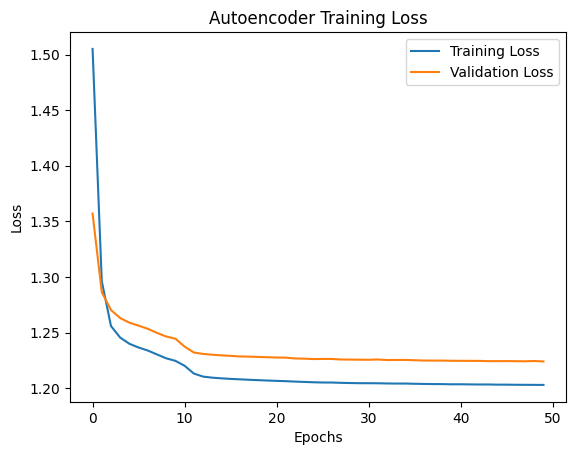

In [25]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Autoencoder Model Workflow

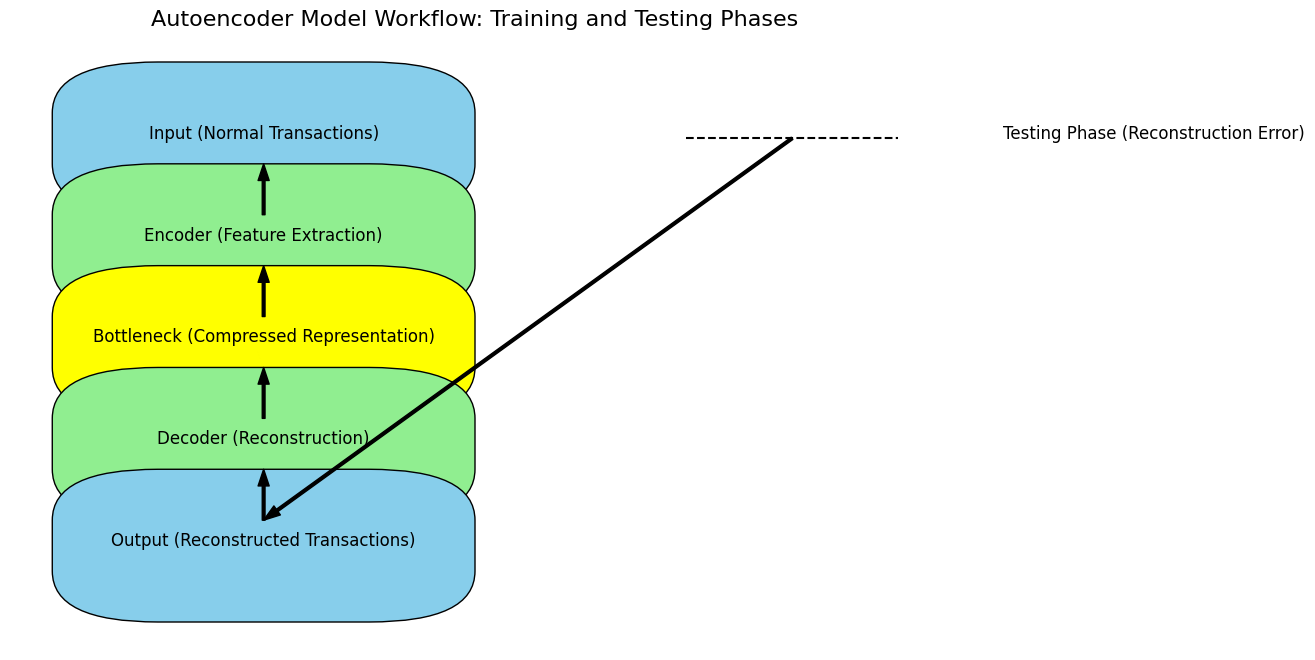

In [4]:
# Importing the necessary Libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Defining the function
def plot_autoencoder_workflow():
    # Create a figure and axis for the diagram
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set the background color
    ax.set_facecolor('white')

    # Remove axes for a cleaner look
    ax.axis('off')

    # Draw the input layer box
    ax.add_patch(patches.FancyBboxPatch((0.1, 0.7), 0.2, 0.1, boxstyle="round,pad=0.1", ec="black", fc="skyblue"))
    ax.text(0.2, 0.75, 'Input (Normal Transactions)', horizontalalignment='center', fontsize=12)

    # Draw the encoder layers
    ax.add_patch(patches.FancyBboxPatch((0.1, 0.5), 0.2, 0.1, boxstyle="round,pad=0.1", ec="black", fc="lightgreen"))
    ax.text(0.2, 0.55, 'Encoder (Feature Extraction)', horizontalalignment='center', fontsize=12)

    # Draw the bottleneck layer
    ax.add_patch(patches.FancyBboxPatch((0.1, 0.3), 0.2, 0.1, boxstyle="round,pad=0.1", ec="black", fc="yellow"))
    ax.text(0.2, 0.35, 'Bottleneck (Compressed Representation)', horizontalalignment='center', fontsize=12)

    # Draw the decoder layers
    ax.add_patch(patches.FancyBboxPatch((0.1, 0.1), 0.2, 0.1, boxstyle="round,pad=0.1", ec="black", fc="lightgreen"))
    ax.text(0.2, 0.15, 'Decoder (Reconstruction)', horizontalalignment='center', fontsize=12)

    # Draw the output layer
    ax.add_patch(patches.FancyBboxPatch((0.1, -0.1), 0.2, 0.1, boxstyle="round,pad=0.1", ec="black", fc="skyblue"))
    ax.text(0.2, -0.05, 'Output (Reconstructed Transactions)', horizontalalignment='center', fontsize=12)

    # Arrow from Input to Encoder
    ax.annotate('', xy=(0.2, 0.7), xytext=(0.2, 0.6),
                arrowprops=dict(facecolor='black', shrinkA=5, shrinkB=5, width=2, headwidth=8))

    # Arrow from Encoder to Bottleneck
    ax.annotate('', xy=(0.2, 0.5), xytext=(0.2, 0.4),
                arrowprops=dict(facecolor='black', shrinkA=5, shrinkB=5, width=2, headwidth=8))

    # Arrow from Bottleneck to Decoder
    ax.annotate('', xy=(0.2, 0.3), xytext=(0.2, 0.2),
                arrowprops=dict(facecolor='black', shrinkA=5, shrinkB=5, width=2, headwidth=8))

    # Arrow from Decoder to Output
    ax.annotate('', xy=(0.2, 0.1), xytext=(0.2, 0),
                arrowprops=dict(facecolor='black', shrinkA=5, shrinkB=5, width=2, headwidth=8))

    # Draw a dashed line for testing phase (reconstruction error calculation)
    ax.plot([0.6, 0.8], [0.75, 0.75], 'k--')  # Horizontal dashed line
    ax.text(0.9, 0.75, 'Testing Phase (Reconstruction Error)', horizontalalignment='left', fontsize=12)

    # Arrow from Output to Testing Phase
    ax.annotate('', xy=(0.2, 0), xytext=(0.7, 0.75),
                arrowprops=dict(facecolor='black', shrinkA=5, shrinkB=5, width=2, headwidth=8))

    plt.title('Autoencoder Model Workflow: Training and Testing Phases', fontsize=16)
    plt.show()

# Call the function to plot the diagram
plot_autoencoder_workflow()


# Anomaly Detection with Autoencoder

In [26]:
# Reconstruction error on test data
X_test_reconstructed = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.square(X_test - X_test_reconstructed), axis=1)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [27]:
# Determine threshold for anomaly detection
threshold = np.percentile(reconstruction_error[y_test == 0], 95)
print(f"\nReconstruction Error Threshold: {threshold}")


Reconstruction Error Threshold: 2.5196568404932487


In [28]:
# Predict anomalies
y_pred_auto = (reconstruction_error > threshold).astype(int)

In [29]:
# Evaluate Autoencoder
print("\nAutoencoder Metrics:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_auto))
print("\nClassification Report:\n", classification_report(y_test, y_pred_auto))
print("\nROC AUC Score:", roc_auc_score(y_test, reconstruction_error))



Autoencoder Metrics:
Confusion Matrix:
 [[54020  2844]
 [   14    84]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.86      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.90      0.51     56962
weighted avg       1.00      0.95      0.97     56962


ROC AUC Score: 0.943027330515774


# Transfer Learning Models

## Isolation Forest

In [30]:
# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
start_time = time.time()
iso_forest.fit(X_train)
end_time = time.time()

print(f"\nIsolation Forest Training Time: {end_time - start_time:.2f} seconds")


Isolation Forest Training Time: 1.49 seconds


In [31]:
# Predict anomalies
y_pred_iso = iso_forest.predict(X_test)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]

In [32]:
# Evaluate Isolation Forest
print("\nIsolation Forest Metrics:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_iso))
print("\nClassification Report:\n", classification_report(y_test, y_pred_iso))
print("\nROC AUC Score:", roc_auc_score(y_test, iso_forest.decision_function(X_test)))


Isolation Forest Metrics:
Confusion Matrix:
 [[56322   542]
 [   33    65]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.66      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.83      0.59     56962
weighted avg       1.00      0.99      0.99     56962


ROC AUC Score: 0.049153978558221255


## One-class SVM

In [33]:
# Train One-Class SVM
svm_model = OneClassSVM(kernel='rbf', nu=0.01, gamma=0.1)
start_time = time.time()
svm_model.fit(X_train_normal)
end_time = time.time()

print(f"\nOne-Class SVM Training Time: {end_time - start_time:.2f} seconds")


One-Class SVM Training Time: 339.17 seconds


In [34]:
# Predict anomalies
y_pred_svm = svm_model.predict(X_test)
y_pred_svm = [1 if x == -1 else 0 for x in y_pred_svm]

In [35]:
# Evaluate One-Class SVM
print("\nOne-Class SVM Metrics:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))
print("\nROC AUC Score:", roc_auc_score(y_test, svm_model.decision_function(X_test)))


One-Class SVM Metrics:
Confusion Matrix:
 [[55509  1355]
 [   13    85]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.87      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.92      0.55     56962
weighted avg       1.00      0.98      0.99     56962


ROC AUC Score: 0.05924455988078968


# Visualization and Comparison

In [36]:
# Compare ROC Curves
fpr_auto, tpr_auto, _ = roc_curve(y_test, reconstruction_error)
fpr_iso, tpr_iso, _ = roc_curve(y_test, iso_forest.decision_function(X_test))
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_model.decision_function(X_test))

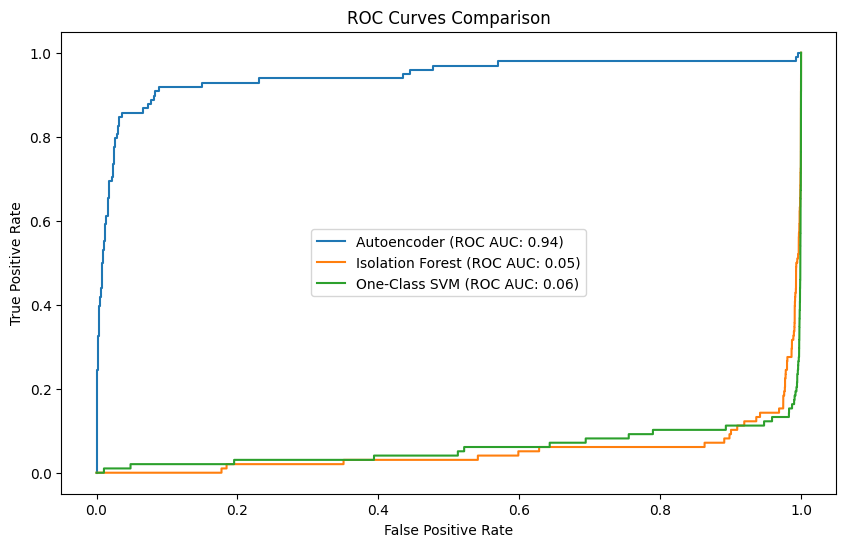

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(fpr_auto, tpr_auto, label='Autoencoder (ROC AUC: {:.2f})'.format(roc_auc_score(y_test, reconstruction_error)))
plt.plot(fpr_iso, tpr_iso, label='Isolation Forest (ROC AUC: {:.2f})'.format(roc_auc_score(y_test, iso_forest.decision_function(X_test))))
plt.plot(fpr_svm, tpr_svm, label='One-Class SVM (ROC AUC: {:.2f})'.format(roc_auc_score(y_test, svm_model.decision_function(X_test))))
plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

<div style="font-family: Arial, sans-serif; text-align: center; background-color: #f0f8ff; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
    <h1 style="color: #4caf50;">Thank You!</h1>
    <p style="color: #555; font-size: 18px; text-align: center; ">Thanks for your patience and understanding! 💖</p>
</div>